# Notebook to generate figure 6
experimental parameters:
- dataset : October 7th, 2020 
- exposure time: 200 ms
- time between images : 12 ms
- number of images in each reference wing: 100

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat, unumpy
import scipy.stats
import os
import math

## Load dataset and define analysis function


In [4]:
#Github_folder =R"C:\Users\Rohit Prasad Bhatt"
#Github_folder =R"C:\Users\Jan"
Github_folder =R"C:\Users\Lilo"
#Github_folder= "/Users/fredjendrzejewski"
PATH_raw = os.path.join(Github_folder, "Documents/GitHub/StocDyn_fig_data/data/Oct07_Scan_0000_Cam_EXPOT=0.2.csv")
PATH_fig = os.path.join(Github_folder, "Documents/GitHub/StocDyn_fig_data/figures")

In [5]:
def analyze(file_path, Cam_EXPOT):
    Counts=pd.read_csv(file_path,  encoding='UTF-8')
    Split_Counts=np.array_split(Counts['Counts'],len(Counts['Run_number'].unique()))
    Split_Counts_array=np.array(Split_Counts)
    Nruns, Nimg = Split_Counts_array.shape
    atom_images = np.size(Split_Counts_array[1])
    time_between_atom_images = 12e-3
    time = np.arange(atom_images)*(time_between_atom_images + Cam_EXPOT)
    return time, Nruns, Nimg, Split_Counts_array;

In [6]:
time_raw, Nruns, Nimg, Split_Counts_array_raw = analyze(PATH_raw, Cam_EXPOT=200e-3)

## Plotting the histogram to extract calibration factor
we plot all the data in a histogram, to extract the calibration factor (the distance between consecutive peaks) which is needed for the digitization of the data

In [7]:
allcounts_offsetremoved=(Split_Counts_array_raw[:,100:300])+0 # make quick deepcopy
offset=np.mean(Split_Counts_array_raw[:,2:89], axis=1) # calculate offset from first reference wing
allcounts_offsetremoved=allcounts_offsetremoved-offset[:,None]
allcounts_offsetremoved=allcounts_offsetremoved.flatten()

In [8]:
bins=np.linspace(-1e4, 7e4, 200)
y, bins = np.histogram(allcounts_offsetremoved, bins=bins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

Define gaussian functions which we use to fit to indivdual atom peaks

In [9]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

In [10]:
def Multimodal(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3,mu4,sigma4,A4,mu5,sigma5,A5,mu6,sigma6,A6):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)+gauss(x,mu4,sigma4,A4)+gauss(x,mu5,sigma5,A5)+gauss(x,mu6,sigma6,A6)

In [11]:
expected=(0,1e3,1800,10e3,1e3,400,2.2e4,1e3,600,3.5e4,6e3,130,4.5e4,3e3,80,6e4,3e3,10)
params,cov=curve_fit(Multimodal,binscenters,y,expected,absolute_sigma=True, bounds=([-1e3,0.1e3,150,6e3,0.1e3,5,2e4,0.1e3,5,3e4,0.1e3,10,4e4,0.1e3,5,5e4,0.1e3,1], [1e3,3e3,22000,12e3,3e3,5000,3e4,3e3,7000,4e4,3e4,200,5e4,2e4,100,6.5e4,1e4,30]))
sigma=np.sqrt(np.diag(cov))

In [12]:
calibration=params[::3]
step_sizes=np.diff(calibration)
calibration_error=params[1::3]
mu_step = np.mean(step_sizes)
print('Mean dist between consecutive peaks {:.2f}'.format(mu_step))
print(np.std(step_sizes))

Mean dist between consecutive peaks 11530.41
400.1613080693069


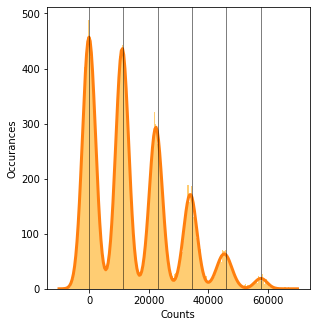

In [14]:
fig2 = plt.figure(figsize=(4.5,5)) 
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot((bins-params[0]),Multimodal(bins,*params),color='C1',lw=3,label='model');
ax2.hist((allcounts_offsetremoved-params[0]),color='orange', bins=bins, label='data',alpha = 0.55)
for ii in range(6):
    ax2.axvline(ii*mu_step, color='black', ls='-', lw=0.5)
ax2.set_xlabel("Counts")
ax2.set_ylabel("Occurances")
fig2.tight_layout()
fig2.subplots_adjust(top=0.9);
my_file = 'Figure6_A.pdf'
fig2.savefig(os.path.join(PATH_fig, my_file)) 

## Information for generating digitized data
We use __generate_digitized_CSV.ipynb__ for generating the digitized data. The neccesary information is given below.

## Calibrate Data and add digitized data
Extract conversion factor from camera counts to atom number using the extracted peak positions and performing a linear fit.

In [15]:
PATH_dig = os.path.join(Github_folder, "Documents/GitHub/StocDyn_fig_data/data/Oct07_Scan_0000_Cam_EXPOT=0.2_digitized.csv")

In [16]:
time_dig, Nruns, Nimg, Split_Counts_array_dig = analyze(PATH_dig, Cam_EXPOT=200e-3)

In [17]:
def lin(x,m,b):
    return m*x+b;

In [18]:
x=np.linspace(0,5,6)
params_lin,cov_lin=curve_fit(lin,x, calibration,sigma=calibration_error, absolute_sigma=True)

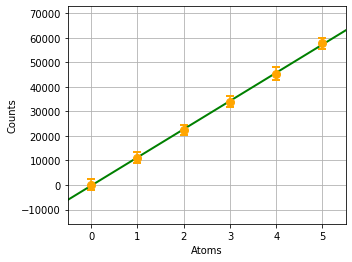

In [19]:
x = np.linspace(-1,6,10)
fig2 = plt.figure(figsize=(5,4)) 
ax2 = fig2.add_subplot(1, 1, 1)
ax2.errorbar(x=np.linspace(0,5,6),y=calibration,yerr=calibration_error,color='orange',fmt='o',markersize=8, linewidth=10, elinewidth=1.5,capsize=4, capthick=2);
ax2.plot(x,lin(x,*params_lin),color='g',lw=2,label='model');
ax2.grid()
ax2.set_xlabel("Atoms")
ax2.set_ylabel("Counts")
ax2.set_xlim(-0.5,5.5)
fig2.tight_layout()
fig2.subplots_adjust(top=0.9);

## Extract Values for detection noise and calibration

In [20]:
delta_bg_val = params[1]
delta_bg_err = np.sqrt(np.diag(cov)[1])
delta_bg = ufloat(delta_bg_val, delta_bg_err)

cal_val = params_lin[0]
cal_err = np.sqrt(np.diag(cov_lin)[0])
cal = ufloat(cal_val, cal_err)

atomic_res = delta_bg/cal

In [21]:
print('Background Noise: {:.2ue}' .format(delta_bg))
print('Calibration C: {:.5ue}' .format(cal))
print('Atomic resolution: {:.2ue}' .format(atomic_res))


Background Noise: (2.2012+/-0.0022)e+03
Calibration C: (1.151320+/-0.052403)e+04
Atomic resolution: (1.912+/-0.087)e-01


## Plot the calibrated time trace together with the digitized data

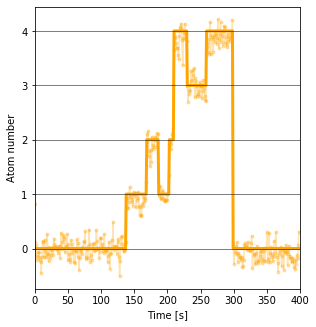

In [23]:
fig = plt.figure(figsize=(4.5,5)) 
ax = fig.add_subplot(1, 1, 1)
y = Split_Counts_array_raw[Nruns-3]
y_dig = Split_Counts_array_dig[Nruns-3]
offset=np.mean(y[0:49])
ax.plot((y-offset)/params_lin[0], '.-', color='orange',alpha=0.3)
ax.plot(y_dig, '-', color='orange', lw=3, alpha=1)
ax.set_xlabel("Time [s]")
for ii in range(5):
    ax.axhline(ii, color='black', ls='-',lw=0.5)
ax.set_ylabel("Atom number")
ax.set_xlim(0,400)
fig.tight_layout()
fig.subplots_adjust(top=0.9);
my_file = 'Figure6_B.pdf'
fig.savefig(os.path.join(PATH_fig, my_file)) 